# mount drive

In [ ]:
use_colaboratory = True
if use_colaboratory:
    import os
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/kaggle/tabular-playground-series-mar-2022/notebook')

Mounted at /content/drive


In [ ]:
# import packages
import datetime
import holidays
import itertools
import math
import pickle

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

%matplotlib inline

### 017-1
016-1にデータ全体の平均値を特徴量として追加

In [ ]:
# load data
train = pd.read_csv("../input/train.csv", index_col="row_id")
test = pd.read_csv("../input/test.csv", index_col="row_id")
train.time = pd.to_datetime(train.time)
test.time = pd.to_datetime(test.time)

In [ ]:
# trainとtestをまとめる
data = pd.concat([train, test])

# 座標と方角をまとめた列を追加
data["loc_dir"] = data.x.astype("str") + data.y.astype("str") + data.direction

In [ ]:
# 時系列の特徴量を追加
data["hour"] = data.time.dt.hour
data["minute"] = data.time.dt.minute
data["weekday"] = data.time.dt.weekday
# data["dayofyear"] = data.time.dt.dayofyear
# data["weekofyear"] = data.time.dt.isocalendar().week
data["isPM"] = (data.hour >= 12).astype("int")
data["isAMrush"] = ((6 <= data.hour) & (data.hour <= 10)).astype("int")
data["isPMrush"] = ((15 <= data.hour) & (data.hour <= 20)).astype("int")
data["isweekend"] = (data.weekday >= 5).astype("int")
data["isnight"] = ((data.hour < 5) & (22 < data.hour)).astype("int")
us_holidays = holidays.US()
data["isholiday"] = (data.time.map(lambda x: x in us_holidays)).astype("int")

# trainデータから座標，方角，曜日，時，分ごとの中央値を計算
medians = data.iloc[:len(train)].groupby(["loc_dir", "weekday", "hour", "minute"]).congestion.median()
medians.name = "wd_h_min_median"
# 中央値を追加
data = data.merge(medians, how="left", left_on=["loc_dir", "weekday", "hour", "minute"], right_index=True)

# trainデータから座標，方角，曜日，時，分ごとの平均値を計算
means = data.iloc[:len(train)].groupby(["loc_dir", "weekday", "hour", "minute"]).congestion.mean()
means.name = "wd_h_min_mean"
# 平均値を追加
data = data.merge(means, how="left", left_on=["loc_dir", "weekday", "hour", "minute"], right_index=True)

In [ ]:
# 元データであるかどうかのフラグ
data["org"] = True

# 抜けたデータポイントを補う
time_index = pd.date_range(start=data.time.iloc[0], end=data.time.iloc[-1], freq="20min")
loc_dir = data.loc_dir.unique()
df = pd.DataFrame(list(itertools.product(time_index, loc_dir)), columns=["time","loc_dir"])
data = df.merge(data, how="left", on=["time", "loc_dir"])

# 追加した行のorgフラグはFalseにする
data.org.fillna(False, inplace=True)

In [ ]:
# シフト特徴量のためのカラムを作製
data["shift_feature"] = data.congestion
# 欠損値は中央値で補完
data.shift_feature.fillna(data.wd_h_min_median, inplace=True)

# シフト特徴量作製のため，wide formatに変更
wide_shift_feature = data.pivot(index="time", columns="loc_dir", values="shift_feature")

# 1日，1週間のシフト特徴量を計算
shift_1d = wide_shift_feature.shift(3*24)
shift_1w = wide_shift_feature.shift(3*24*7)
# long formatに戻す
shift_1d = shift_1d.stack()
shift_1d.name = "shift_1d"
shift_1d = shift_1d.reset_index()
shift_1w = shift_1w.stack()
shift_1w.name = "shift_1w"
shift_1w = shift_1w.reset_index()

# 特徴量として追加
data = data.merge(shift_1d, how="left", on=["time", "loc_dir"])
data = data.merge(shift_1w, how="left", on=["time", "loc_dir"])

# 座標，方角，曜日，時間，分，をone-hot-encoding
data = pd.get_dummies(data, columns=["x", "y", "direction", "hour", "minute"])

# 元データのみ取り出す
data = data[data.org]

In [ ]:
# trainとtestに再分割
train = data.iloc[:len(train)]
test = data.iloc[len(train):]

# 欠損値のある行を除く
train = train.dropna()

# 特徴量，目的変数に分ける
X_train = train.drop(["time", "loc_dir", "congestion", "shift_feature", "org"], axis=1)
y_train = train.congestion
X_test = test.drop(["time", "loc_dir", "congestion", "shift_feature", "org"], axis=1)

In [ ]:
# 保存用の配列
y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv_idx = []


params = {
    "objective": "regression",
    "metric": "mae",
    "learning_rate": 0.05,
}

# 時系列で交差検証
cv = TimeSeriesSplit(n_splits=5)

for fold_idx, (tr_idx, val_idx) in enumerate(cv.split(X_train)):
    cv_idx.append({"train": tr_idx, "valid": val_idx})
    print(f"======== fold: {fold_idx} ========")

    # 学習用，バリデーション用に分割
    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    
    model = lgb.train(params, lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=10,
                      num_boost_round=3000,
                      early_stopping_rounds=10)
    
    oof_train[val_idx] = \
        model.predict(X_val, num_iteration=model.best_iteration)

    y_pred = model.predict(X_test, num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)

======== fold: 0 ========
Training until validation scores don't improve for 10 rounds.
[10]	training's l1: 9.77858	valid_1's l1: 9.74821
[20]	training's l1: 7.66133	valid_1's l1: 7.667
[30]	training's l1: 6.64258	valid_1's l1: 6.67821
[40]	training's l1: 6.18204	valid_1's l1: 6.24525
[50]	training's l1: 5.97677	valid_1's l1: 6.06499
[60]	training's l1: 5.88296	valid_1's l1: 5.99147
[70]	training's l1: 5.83559	valid_1's l1: 5.96153
[80]	training's l1: 5.80806	valid_1's l1: 5.94774
[90]	training's l1: 5.78974	valid_1's l1: 5.94115
[100]	training's l1: 5.77489	valid_1's l1: 5.93763
[110]	training's l1: 5.76358	valid_1's l1: 5.93566
[120]	training's l1: 5.75293	valid_1's l1: 5.93479
[130]	training's l1: 5.74489	valid_1's l1: 5.93406
[140]	training's l1: 5.73791	valid_1's l1: 5.93461
Early stopping, best iteration is:
[134]	training's l1: 5.74211	valid_1's l1: 5.93405
======== fold: 1 ========
Training until validation scores don't improve for 10 rounds.
[10]	training's l1: 9.77329	valid_1

In [ ]:
with open("../output/y_preds_017-1.pkl", "wb") as f:
    pickle.dump(y_preds, f)

with open("../output/models_017-1.pkl", "wb") as f:
    pickle.dump(models, f)

with open("../output/oof_train_017-1.pkl", "wb") as f:
    pickle.dump(oof_train, f)

In [ ]:
scores = [
    m.best_score["valid_1"]["l1"] for m in models
]
score = sum(scores) / len(scores)
print("=== CV scores ===")
print(scores)
print(score)

=== CV scores ===
[5.934048893133215, 6.004706479034065, 6.158148366912598, 6.033399017668306, 6.337982138710794]
6.093656979091795


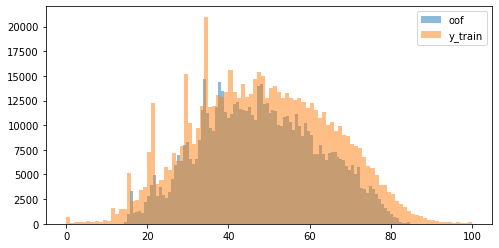

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(oof_train[len(cv_idx[0]["train"]):], bins=100, label="oof", alpha=0.5)
plt.hist(train.iloc[len(cv_idx[0]["train"]):].congestion, bins=100, label="y_train", alpha=0.5)
plt.legend()
plt.show()

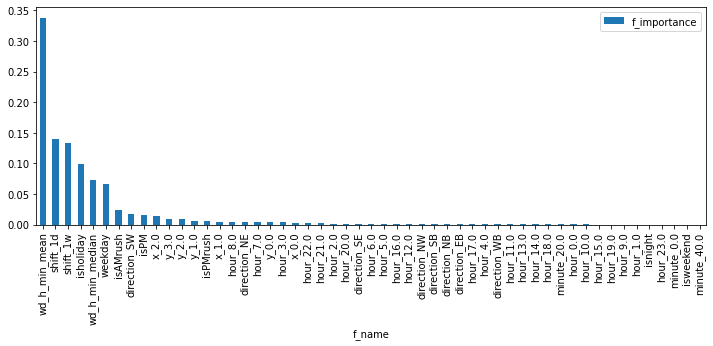

In [ ]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 1, 1)

f_importance = models[-1].feature_importance()
f_importance = f_importance / np.sum(f_importance)
f_name = models[-1].feature_name()

df_importance = pd.DataFrame({"f_name": f_name, "f_importance": f_importance})
df_importance = df_importance.sort_values("f_importance", ascending=False)

df_importance.plot.bar(x="f_name", ax=ax)

### 017-2
017-1の特徴量からminuteを削除

In [ ]:
# load data
train = pd.read_csv("../input/train.csv", index_col="row_id")
test = pd.read_csv("../input/test.csv", index_col="row_id")
train.time = pd.to_datetime(train.time)
test.time = pd.to_datetime(test.time)

In [ ]:
# trainとtestをまとめる
data = pd.concat([train, test])

# 座標と方角をまとめた列を追加
data["loc_dir"] = data.x.astype("str") + data.y.astype("str") + data.direction

In [ ]:
# 時系列の特徴量を追加
data["hour"] = data.time.dt.hour
data["minute"] = data.time.dt.minute
data["weekday"] = data.time.dt.weekday
# data["dayofyear"] = data.time.dt.dayofyear
# data["weekofyear"] = data.time.dt.isocalendar().week
data["isPM"] = (data.hour >= 12).astype("int")
data["isAMrush"] = ((6 <= data.hour) & (data.hour <= 10)).astype("int")
data["isPMrush"] = ((15 <= data.hour) & (data.hour <= 20)).astype("int")
data["isweekend"] = (data.weekday >= 5).astype("int")
data["isnight"] = ((data.hour < 5) & (22 < data.hour)).astype("int")
us_holidays = holidays.US()
data["isholiday"] = (data.time.map(lambda x: x in us_holidays)).astype("int")

# trainデータから座標，方角，曜日，時，分ごとの中央値を計算
medians = data.iloc[:len(train)].groupby(["loc_dir", "weekday", "hour", "minute"]).congestion.median()
medians.name = "wd_h_min_median"
# 中央値を追加
data = data.merge(medians, how="left", left_on=["loc_dir", "weekday", "hour", "minute"], right_index=True)

# trainデータから座標，方角，曜日，時，分ごとの平均値を計算
means = data.iloc[:len(train)].groupby(["loc_dir", "weekday", "hour", "minute"]).congestion.mean()
means.name = "wd_h_min_mean"
# 平均値を追加
data = data.merge(means, how="left", left_on=["loc_dir", "weekday", "hour", "minute"], right_index=True)

In [ ]:
# 元データであるかどうかのフラグ
data["org"] = True

# 抜けたデータポイントを補う
time_index = pd.date_range(start=data.time.iloc[0], end=data.time.iloc[-1], freq="20min")
loc_dir = data.loc_dir.unique()
df = pd.DataFrame(list(itertools.product(time_index, loc_dir)), columns=["time","loc_dir"])
data = df.merge(data, how="left", on=["time", "loc_dir"])

# 追加した行のorgフラグはFalseにする
data.org.fillna(False, inplace=True)

In [ ]:
# シフト特徴量のためのカラムを作製
data["shift_feature"] = data.congestion
# 欠損値は中央値で補完
data.shift_feature.fillna(data.wd_h_min_median, inplace=True)

# シフト特徴量作製のため，wide formatに変更
wide_shift_feature = data.pivot(index="time", columns="loc_dir", values="shift_feature")

# 1日，1週間のシフト特徴量を計算
shift_1d = wide_shift_feature.shift(3*24)
shift_1w = wide_shift_feature.shift(3*24*7)
# long formatに戻す
shift_1d = shift_1d.stack()
shift_1d.name = "shift_1d"
shift_1d = shift_1d.reset_index()
shift_1w = shift_1w.stack()
shift_1w.name = "shift_1w"
shift_1w = shift_1w.reset_index()

# 特徴量として追加
data = data.merge(shift_1d, how="left", on=["time", "loc_dir"])
data = data.merge(shift_1w, how="left", on=["time", "loc_dir"])

# 座標，方角，曜日，時間をone-hot-encoding
data = pd.get_dummies(data, columns=["x", "y", "direction", "hour"])

# 元データのみ取り出す
data = data[data.org]

In [ ]:
# trainとtestに再分割
train = data.iloc[:len(train)]
test = data.iloc[len(train):]

# 欠損値のある行を除く
train = train.dropna()

# 特徴量，目的変数に分ける
X_train = train.drop(["time", "loc_dir", "congestion", "minute", "shift_feature", "org"], axis=1)
y_train = train.congestion
X_test = test.drop(["time", "loc_dir", "congestion", "minute", "shift_feature", "org"], axis=1)

In [ ]:
# 保存用の配列
y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv_idx = []


params = {
    "objective": "regression",
    "metric": "mae",
    "learning_rate": 0.05,
}

# 時系列で交差検証
cv = TimeSeriesSplit(n_splits=5)

for fold_idx, (tr_idx, val_idx) in enumerate(cv.split(X_train)):
    cv_idx.append({"train": tr_idx, "valid": val_idx})
    print(f"======== fold: {fold_idx} ========")

    # 学習用，バリデーション用に分割
    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    
    model = lgb.train(params, lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=10,
                      num_boost_round=3000,
                      early_stopping_rounds=10)
    
    oof_train[val_idx] = \
        model.predict(X_val, num_iteration=model.best_iteration)

    y_pred = model.predict(X_test, num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)

======== fold: 0 ========
Training until validation scores don't improve for 10 rounds.
[10]	training's l1: 9.77858	valid_1's l1: 9.74821
[20]	training's l1: 7.66133	valid_1's l1: 7.667
[30]	training's l1: 6.64258	valid_1's l1: 6.67821
[40]	training's l1: 6.18201	valid_1's l1: 6.24529
[50]	training's l1: 5.97704	valid_1's l1: 6.06509
[60]	training's l1: 5.88327	valid_1's l1: 5.99147
[70]	training's l1: 5.83593	valid_1's l1: 5.96089
[80]	training's l1: 5.80881	valid_1's l1: 5.94733
[90]	training's l1: 5.78993	valid_1's l1: 5.94018
[100]	training's l1: 5.7762	valid_1's l1: 5.93682
[110]	training's l1: 5.76385	valid_1's l1: 5.93526
[120]	training's l1: 5.75297	valid_1's l1: 5.93479
[130]	training's l1: 5.74505	valid_1's l1: 5.93472
[140]	training's l1: 5.73826	valid_1's l1: 5.93512
Early stopping, best iteration is:
[132]	training's l1: 5.74335	valid_1's l1: 5.93446
======== fold: 1 ========
Training until validation scores don't improve for 10 rounds.
[10]	training's l1: 9.77329	valid_1'

In [ ]:
with open("../output/y_preds_017-2.pkl", "wb") as f:
    pickle.dump(y_preds, f)

with open("../output/models_017-2.pkl", "wb") as f:
    pickle.dump(models, f)

with open("../output/oof_train_017-2.pkl", "wb") as f:
    pickle.dump(oof_train, f)

In [ ]:
scores = [
    m.best_score["valid_1"]["l1"] for m in models
]
score = sum(scores) / len(scores)
print("=== CV scores ===")
print(scores)
print(score)

=== CV scores ===
[5.934455284280861, 6.004451074717233, 6.15742450358178, 6.033368044635511, 6.338028648455045]
6.093545511134086


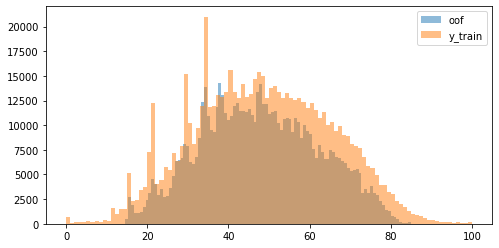

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(oof_train[len(cv_idx[0]["train"]):], bins=100, label="oof", alpha=0.5)
plt.hist(train.iloc[len(cv_idx[0]["train"]):].congestion, bins=100, label="y_train", alpha=0.5)
plt.legend()
plt.show()

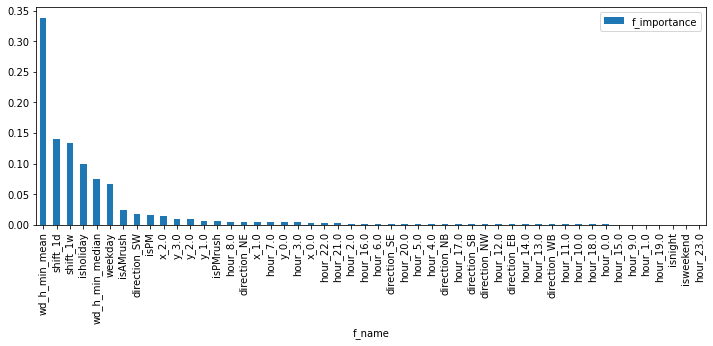

In [ ]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 1, 1)

f_importance = models[-1].feature_importance()
f_importance = f_importance / np.sum(f_importance)
f_name = models[-1].feature_name()

df_importance = pd.DataFrame({"f_name": f_name, "f_importance": f_importance})
df_importance = df_importance.sort_values("f_importance", ascending=False)

df_importance.plot.bar(x="f_name", ax=ax)

### 017-3
017-2のweekdayをone-hot-encoding

In [ ]:
# load data
train = pd.read_csv("../input/train.csv", index_col="row_id")
test = pd.read_csv("../input/test.csv", index_col="row_id")
train.time = pd.to_datetime(train.time)
test.time = pd.to_datetime(test.time)

In [ ]:
# trainとtestをまとめる
data = pd.concat([train, test])

# 座標と方角をまとめた列を追加
data["loc_dir"] = data.x.astype("str") + data.y.astype("str") + data.direction

In [ ]:
# 時系列の特徴量を追加
data["hour"] = data.time.dt.hour
data["minute"] = data.time.dt.minute
data["weekday"] = data.time.dt.weekday
# data["dayofyear"] = data.time.dt.dayofyear
# data["weekofyear"] = data.time.dt.isocalendar().week
data["isPM"] = (data.hour >= 12).astype("int")
data["isAMrush"] = ((6 <= data.hour) & (data.hour <= 10)).astype("int")
data["isPMrush"] = ((15 <= data.hour) & (data.hour <= 20)).astype("int")
data["isweekend"] = (data.weekday >= 5).astype("int")
data["isnight"] = ((data.hour < 5) & (22 < data.hour)).astype("int")
us_holidays = holidays.US()
data["isholiday"] = (data.time.map(lambda x: x in us_holidays)).astype("int")

# trainデータから座標，方角，曜日，時，分ごとの中央値を計算
medians = data.iloc[:len(train)].groupby(["loc_dir", "weekday", "hour", "minute"]).congestion.median()
medians.name = "wd_h_min_median"
# 中央値を追加
data = data.merge(medians, how="left", left_on=["loc_dir", "weekday", "hour", "minute"], right_index=True)

# trainデータから座標，方角，曜日，時，分ごとの平均値を計算
means = data.iloc[:len(train)].groupby(["loc_dir", "weekday", "hour", "minute"]).congestion.mean()
means.name = "wd_h_min_mean"
# 平均値を追加
data = data.merge(means, how="left", left_on=["loc_dir", "weekday", "hour", "minute"], right_index=True)

In [ ]:
# 元データであるかどうかのフラグ
data["org"] = True

# 抜けたデータポイントを補う
time_index = pd.date_range(start=data.time.iloc[0], end=data.time.iloc[-1], freq="20min")
loc_dir = data.loc_dir.unique()
df = pd.DataFrame(list(itertools.product(time_index, loc_dir)), columns=["time","loc_dir"])
data = df.merge(data, how="left", on=["time", "loc_dir"])

# 追加した行のorgフラグはFalseにする
data.org.fillna(False, inplace=True)

In [ ]:
# シフト特徴量のためのカラムを作製
data["shift_feature"] = data.congestion
# 欠損値は中央値で補完
data.shift_feature.fillna(data.wd_h_min_median, inplace=True)

# シフト特徴量作製のため，wide formatに変更
wide_shift_feature = data.pivot(index="time", columns="loc_dir", values="shift_feature")

# 1日，1週間のシフト特徴量を計算
shift_1d = wide_shift_feature.shift(3*24)
shift_1w = wide_shift_feature.shift(3*24*7)
# long formatに戻す
shift_1d = shift_1d.stack()
shift_1d.name = "shift_1d"
shift_1d = shift_1d.reset_index()
shift_1w = shift_1w.stack()
shift_1w.name = "shift_1w"
shift_1w = shift_1w.reset_index()

# 特徴量として追加
data = data.merge(shift_1d, how="left", on=["time", "loc_dir"])
data = data.merge(shift_1w, how="left", on=["time", "loc_dir"])

# 座標，方角，曜日，時間をone-hot-encoding
data = pd.get_dummies(data, columns=["x", "y", "direction", "weekday", "hour"])

# 元データのみ取り出す
data = data[data.org]

In [ ]:
# trainとtestに再分割
train = data.iloc[:len(train)]
test = data.iloc[len(train):]

# 欠損値のある行を除く
train = train.dropna()

# 特徴量，目的変数に分ける
X_train = train.drop(["time", "loc_dir", "congestion", "minute", "shift_feature", "org"], axis=1)
y_train = train.congestion
X_test = test.drop(["time", "loc_dir", "congestion", "minute", "shift_feature", "org"], axis=1)

In [ ]:
# 保存用の配列
y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv_idx = []


params = {
    "objective": "regression",
    "metric": "mae",
    "learning_rate": 0.05,
}

# 時系列で交差検証
cv = TimeSeriesSplit(n_splits=5)

for fold_idx, (tr_idx, val_idx) in enumerate(cv.split(X_train)):
    cv_idx.append({"train": tr_idx, "valid": val_idx})
    print(f"======== fold: {fold_idx} ========")

    # 学習用，バリデーション用に分割
    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    
    model = lgb.train(params, lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=10,
                      num_boost_round=3000,
                      early_stopping_rounds=10)
    
    oof_train[val_idx] = \
        model.predict(X_val, num_iteration=model.best_iteration)

    y_pred = model.predict(X_test, num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)

======== fold: 0 ========
Training until validation scores don't improve for 10 rounds.
[10]	training's l1: 9.77858	valid_1's l1: 9.74821
[20]	training's l1: 7.66133	valid_1's l1: 7.667
[30]	training's l1: 6.64246	valid_1's l1: 6.67821
[40]	training's l1: 6.18197	valid_1's l1: 6.24555
[50]	training's l1: 5.97611	valid_1's l1: 6.06475
[60]	training's l1: 5.88155	valid_1's l1: 5.99131
[70]	training's l1: 5.83315	valid_1's l1: 5.96065
[80]	training's l1: 5.80606	valid_1's l1: 5.94803
[90]	training's l1: 5.78825	valid_1's l1: 5.94132
[100]	training's l1: 5.77313	valid_1's l1: 5.93797
[110]	training's l1: 5.76131	valid_1's l1: 5.93656
Early stopping, best iteration is:
[107]	training's l1: 5.76429	valid_1's l1: 5.93634
======== fold: 1 ========
Training until validation scores don't improve for 10 rounds.
[10]	training's l1: 9.77329	valid_1's l1: 9.89884
[20]	training's l1: 7.6717	valid_1's l1: 7.80363
[30]	training's l1: 6.66182	valid_1's l1: 6.79907
[40]	training's l1: 6.20729	valid_1's l

In [ ]:
with open("../output/y_preds_017-3.pkl", "wb") as f:
    pickle.dump(y_preds, f)

with open("../output/models_017-3.pkl", "wb") as f:
    pickle.dump(models, f)

with open("../output/oof_train_017-3.pkl", "wb") as f:
    pickle.dump(oof_train, f)

In [ ]:
scores = [
    m.best_score["valid_1"]["l1"] for m in models
]
score = sum(scores) / len(scores)
print("=== CV scores ===")
print(scores)
print(score)

=== CV scores ===
[5.936336637855129, 6.004111145412145, 6.159265524116984, 6.032858825123762, 6.337490707630784]
6.09401256802776


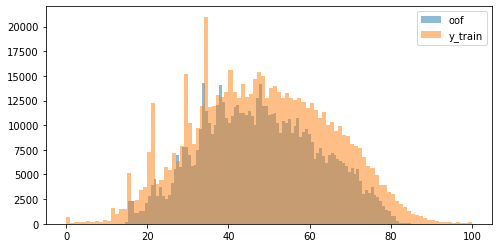

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(oof_train[len(cv_idx[0]["train"]):], bins=100, label="oof", alpha=0.5)
plt.hist(train.iloc[len(cv_idx[0]["train"]):].congestion, bins=100, label="y_train", alpha=0.5)
plt.legend()
plt.show()

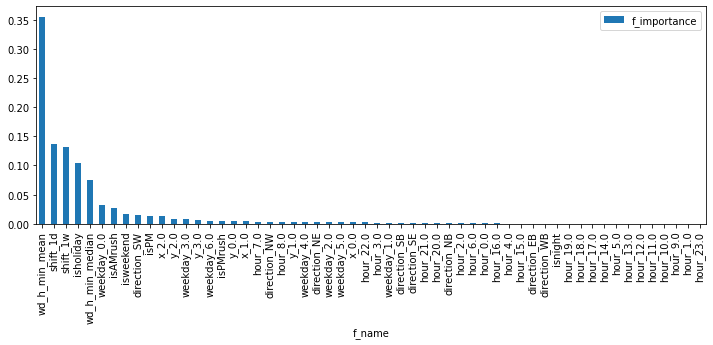

In [ ]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 1, 1)

f_importance = models[-1].feature_importance()
f_importance = f_importance / np.sum(f_importance)
f_name = models[-1].feature_name()

df_importance = pd.DataFrame({"f_name": f_name, "f_importance": f_importance})
df_importance = df_importance.sort_values("f_importance", ascending=False)

df_importance.plot.bar(x="f_name", ax=ax)

### 017-4
017-2のhourのone-hot-encodingをやめる

In [ ]:
# load data
train = pd.read_csv("../input/train.csv", index_col="row_id")
test = pd.read_csv("../input/test.csv", index_col="row_id")
train.time = pd.to_datetime(train.time)
test.time = pd.to_datetime(test.time)

In [ ]:
# trainとtestをまとめる
data = pd.concat([train, test])

# 座標と方角をまとめた列を追加
data["loc_dir"] = data.x.astype("str") + data.y.astype("str") + data.direction

In [ ]:
# 時系列の特徴量を追加
data["hour"] = data.time.dt.hour
data["minute"] = data.time.dt.minute
data["weekday"] = data.time.dt.weekday
# data["dayofyear"] = data.time.dt.dayofyear
# data["weekofyear"] = data.time.dt.isocalendar().week
data["isPM"] = (data.hour >= 12).astype("int")
data["isAMrush"] = ((6 <= data.hour) & (data.hour <= 10)).astype("int")
data["isPMrush"] = ((15 <= data.hour) & (data.hour <= 20)).astype("int")
data["isweekend"] = (data.weekday >= 5).astype("int")
data["isnight"] = ((data.hour < 5) & (22 < data.hour)).astype("int")
us_holidays = holidays.US()
data["isholiday"] = (data.time.map(lambda x: x in us_holidays)).astype("int")

# trainデータから座標，方角，曜日，時，分ごとの中央値を計算
medians = data.iloc[:len(train)].groupby(["loc_dir", "weekday", "hour", "minute"]).congestion.median()
medians.name = "wd_h_min_median"
# 中央値を追加
data = data.merge(medians, how="left", left_on=["loc_dir", "weekday", "hour", "minute"], right_index=True)

# trainデータから座標，方角，曜日，時，分ごとの平均値を計算
means = data.iloc[:len(train)].groupby(["loc_dir", "weekday", "hour", "minute"]).congestion.mean()
means.name = "wd_h_min_mean"
# 平均値を追加
data = data.merge(means, how="left", left_on=["loc_dir", "weekday", "hour", "minute"], right_index=True)

In [ ]:
# 元データであるかどうかのフラグ
data["org"] = True

# 抜けたデータポイントを補う
time_index = pd.date_range(start=data.time.iloc[0], end=data.time.iloc[-1], freq="20min")
loc_dir = data.loc_dir.unique()
df = pd.DataFrame(list(itertools.product(time_index, loc_dir)), columns=["time","loc_dir"])
data = df.merge(data, how="left", on=["time", "loc_dir"])

# 追加した行のorgフラグはFalseにする
data.org.fillna(False, inplace=True)

In [ ]:
# シフト特徴量のためのカラムを作製
data["shift_feature"] = data.congestion
# 欠損値は中央値で補完
data.shift_feature.fillna(data.wd_h_min_median, inplace=True)

# シフト特徴量作製のため，wide formatに変更
wide_shift_feature = data.pivot(index="time", columns="loc_dir", values="shift_feature")

# 1日，1週間のシフト特徴量を計算
shift_1d = wide_shift_feature.shift(3*24)
shift_1w = wide_shift_feature.shift(3*24*7)
# long formatに戻す
shift_1d = shift_1d.stack()
shift_1d.name = "shift_1d"
shift_1d = shift_1d.reset_index()
shift_1w = shift_1w.stack()
shift_1w.name = "shift_1w"
shift_1w = shift_1w.reset_index()

# 特徴量として追加
data = data.merge(shift_1d, how="left", on=["time", "loc_dir"])
data = data.merge(shift_1w, how="left", on=["time", "loc_dir"])

# 座標，方角をone-hot-encoding
data = pd.get_dummies(data, columns=["x", "y", "direction"])

# 元データのみ取り出す
data = data[data.org]

In [ ]:
# trainとtestに再分割
train = data.iloc[:len(train)]
test = data.iloc[len(train):]

# 欠損値のある行を除く
train = train.dropna()

# 特徴量，目的変数に分ける
X_train = train.drop(["time", "loc_dir", "congestion", "minute", "shift_feature", "org"], axis=1)
y_train = train.congestion
X_test = test.drop(["time", "loc_dir", "congestion", "minute", "shift_feature", "org"], axis=1)

In [ ]:
# 保存用の配列
y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv_idx = []


params = {
    "objective": "regression",
    "metric": "mae",
    "learning_rate": 0.05,
}

# 時系列で交差検証
cv = TimeSeriesSplit(n_splits=5)

for fold_idx, (tr_idx, val_idx) in enumerate(cv.split(X_train)):
    cv_idx.append({"train": tr_idx, "valid": val_idx})
    print(f"======== fold: {fold_idx} ========")

    # 学習用，バリデーション用に分割
    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    
    model = lgb.train(params, lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=10,
                      num_boost_round=3000,
                      early_stopping_rounds=10)
    
    oof_train[val_idx] = \
        model.predict(X_val, num_iteration=model.best_iteration)

    y_pred = model.predict(X_test, num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)

======== fold: 0 ========
Training until validation scores don't improve for 10 rounds.
[10]	training's l1: 9.77858	valid_1's l1: 9.74821
[20]	training's l1: 7.6608	valid_1's l1: 7.66643
[30]	training's l1: 6.64258	valid_1's l1: 6.67771
[40]	training's l1: 6.1816	valid_1's l1: 6.24368
[50]	training's l1: 5.97702	valid_1's l1: 6.06248
[60]	training's l1: 5.8826	valid_1's l1: 5.98878
[70]	training's l1: 5.83466	valid_1's l1: 5.95781
[80]	training's l1: 5.80514	valid_1's l1: 5.9444
[90]	training's l1: 5.78594	valid_1's l1: 5.93856
[100]	training's l1: 5.77125	valid_1's l1: 5.93568
[110]	training's l1: 5.75939	valid_1's l1: 5.93545
[120]	training's l1: 5.74925	valid_1's l1: 5.93475
[130]	training's l1: 5.74087	valid_1's l1: 5.93524
Early stopping, best iteration is:
[126]	training's l1: 5.7444	valid_1's l1: 5.93469
======== fold: 1 ========
Training until validation scores don't improve for 10 rounds.
[10]	training's l1: 9.77329	valid_1's l1: 9.89884
[20]	training's l1: 7.67158	valid_1's l

In [ ]:
with open("../output/y_preds_017-4.pkl", "wb") as f:
    pickle.dump(y_preds, f)

with open("../output/models_017-4.pkl", "wb") as f:
    pickle.dump(models, f)

with open("../output/oof_train_017-4.pkl", "wb") as f:
    pickle.dump(oof_train, f)

In [ ]:
scores = [
    m.best_score["valid_1"]["l1"] for m in models
]
score = sum(scores) / len(scores)
print("=== CV scores ===")
print(scores)
print(score)

=== CV scores ===
[5.934691363434254, 6.003387225686682, 6.160687292583389, 6.034484463390831, 6.3375280331906465]
6.094155675657161


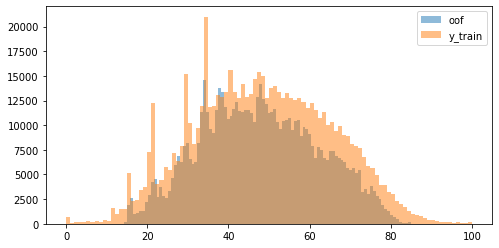

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(oof_train[len(cv_idx[0]["train"]):], bins=100, label="oof", alpha=0.5)
plt.hist(train.iloc[len(cv_idx[0]["train"]):].congestion, bins=100, label="y_train", alpha=0.5)
plt.legend()
plt.show()

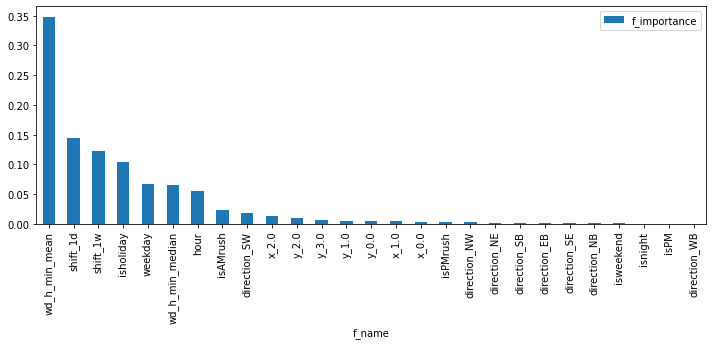

In [ ]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 1, 1)

f_importance = models[-1].feature_importance()
f_importance = f_importance / np.sum(f_importance)
f_name = models[-1].feature_name()

df_importance = pd.DataFrame({"f_name": f_name, "f_importance": f_importance})
df_importance = df_importance.sort_values("f_importance", ascending=False)

df_importance.plot.bar(x="f_name", ax=ax)

### 017-5
017-2の特徴量からisweekendを削除

In [ ]:
# load data
train = pd.read_csv("../input/train.csv", index_col="row_id")
test = pd.read_csv("../input/test.csv", index_col="row_id")
train.time = pd.to_datetime(train.time)
test.time = pd.to_datetime(test.time)

In [ ]:
# trainとtestをまとめる
data = pd.concat([train, test])

# 座標と方角をまとめた列を追加
data["loc_dir"] = data.x.astype("str") + data.y.astype("str") + data.direction

In [ ]:
# 時系列の特徴量を追加
data["hour"] = data.time.dt.hour
data["minute"] = data.time.dt.minute
data["weekday"] = data.time.dt.weekday
# data["dayofyear"] = data.time.dt.dayofyear
# data["weekofyear"] = data.time.dt.isocalendar().week
data["isPM"] = (data.hour >= 12).astype("int")
data["isAMrush"] = ((6 <= data.hour) & (data.hour <= 10)).astype("int")
data["isPMrush"] = ((15 <= data.hour) & (data.hour <= 20)).astype("int")
# data["isweekend"] = (data.weekday >= 5).astype("int")
data["isnight"] = ((data.hour < 5) & (22 < data.hour)).astype("int")
us_holidays = holidays.US()
data["isholiday"] = (data.time.map(lambda x: x in us_holidays)).astype("int")

# trainデータから座標，方角，曜日，時，分ごとの中央値を計算
medians = data.iloc[:len(train)].groupby(["loc_dir", "weekday", "hour", "minute"]).congestion.median()
medians.name = "wd_h_min_median"
# 中央値を追加
data = data.merge(medians, how="left", left_on=["loc_dir", "weekday", "hour", "minute"], right_index=True)

# trainデータから座標，方角，曜日，時，分ごとの平均値を計算
means = data.iloc[:len(train)].groupby(["loc_dir", "weekday", "hour", "minute"]).congestion.mean()
means.name = "wd_h_min_mean"
# 平均値を追加
data = data.merge(means, how="left", left_on=["loc_dir", "weekday", "hour", "minute"], right_index=True)

In [ ]:
# 元データであるかどうかのフラグ
data["org"] = True

# 抜けたデータポイントを補う
time_index = pd.date_range(start=data.time.iloc[0], end=data.time.iloc[-1], freq="20min")
loc_dir = data.loc_dir.unique()
df = pd.DataFrame(list(itertools.product(time_index, loc_dir)), columns=["time","loc_dir"])
data = df.merge(data, how="left", on=["time", "loc_dir"])

# 追加した行のorgフラグはFalseにする
data.org.fillna(False, inplace=True)

In [ ]:
# シフト特徴量のためのカラムを作製
data["shift_feature"] = data.congestion
# 欠損値は中央値で補完
data.shift_feature.fillna(data.wd_h_min_median, inplace=True)

# シフト特徴量作製のため，wide formatに変更
wide_shift_feature = data.pivot(index="time", columns="loc_dir", values="shift_feature")

# 1日，1週間のシフト特徴量を計算
shift_1d = wide_shift_feature.shift(3*24)
shift_1w = wide_shift_feature.shift(3*24*7)
# long formatに戻す
shift_1d = shift_1d.stack()
shift_1d.name = "shift_1d"
shift_1d = shift_1d.reset_index()
shift_1w = shift_1w.stack()
shift_1w.name = "shift_1w"
shift_1w = shift_1w.reset_index()

# 特徴量として追加
data = data.merge(shift_1d, how="left", on=["time", "loc_dir"])
data = data.merge(shift_1w, how="left", on=["time", "loc_dir"])

# 座標，方角，曜日，時間をone-hot-encoding
data = pd.get_dummies(data, columns=["x", "y", "direction", "hour"])

# 元データのみ取り出す
data = data[data.org]

In [ ]:
# trainとtestに再分割
train = data.iloc[:len(train)]
test = data.iloc[len(train):]

# 欠損値のある行を除く
train = train.dropna()

# 特徴量，目的変数に分ける
X_train = train.drop(["time", "loc_dir", "congestion", "minute", "shift_feature", "org"], axis=1)
y_train = train.congestion
X_test = test.drop(["time", "loc_dir", "congestion", "minute", "shift_feature", "org"], axis=1)

In [ ]:
# 保存用の配列
y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv_idx = []


params = {
    "objective": "regression",
    "metric": "mae",
    "learning_rate": 0.05,
}

# 時系列で交差検証
cv = TimeSeriesSplit(n_splits=5)

for fold_idx, (tr_idx, val_idx) in enumerate(cv.split(X_train)):
    cv_idx.append({"train": tr_idx, "valid": val_idx})
    print(f"======== fold: {fold_idx} ========")

    # 学習用，バリデーション用に分割
    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    
    model = lgb.train(params, lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=10,
                      num_boost_round=3000,
                      early_stopping_rounds=10)
    
    oof_train[val_idx] = \
        model.predict(X_val, num_iteration=model.best_iteration)

    y_pred = model.predict(X_test, num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)

======== fold: 0 ========
Training until validation scores don't improve for 10 rounds.
[10]	training's l1: 9.77858	valid_1's l1: 9.74821
[20]	training's l1: 7.66133	valid_1's l1: 7.667
[30]	training's l1: 6.64258	valid_1's l1: 6.67821
[40]	training's l1: 6.18201	valid_1's l1: 6.24529
[50]	training's l1: 5.97704	valid_1's l1: 6.06509
[60]	training's l1: 5.88327	valid_1's l1: 5.99147
[70]	training's l1: 5.83593	valid_1's l1: 5.96089
[80]	training's l1: 5.80881	valid_1's l1: 5.94733
[90]	training's l1: 5.78993	valid_1's l1: 5.94018
[100]	training's l1: 5.7762	valid_1's l1: 5.93682
[110]	training's l1: 5.76385	valid_1's l1: 5.93526
[120]	training's l1: 5.75297	valid_1's l1: 5.93479
[130]	training's l1: 5.74505	valid_1's l1: 5.93472
[140]	training's l1: 5.73826	valid_1's l1: 5.93512
Early stopping, best iteration is:
[132]	training's l1: 5.74335	valid_1's l1: 5.93446
======== fold: 1 ========
Training until validation scores don't improve for 10 rounds.
[10]	training's l1: 9.77329	valid_1'

In [ ]:
with open("../output/y_preds_017-5.pkl", "wb") as f:
    pickle.dump(y_preds, f)

with open("../output/models_017-5.pkl", "wb") as f:
    pickle.dump(models, f)

with open("../output/oof_train_017-5.pkl", "wb") as f:
    pickle.dump(oof_train, f)

In [ ]:
scores = [
    m.best_score["valid_1"]["l1"] for m in models
]
score = sum(scores) / len(scores)
print("=== CV scores ===")
print(scores)
print(score)

=== CV scores ===
[5.934455284280861, 6.004451074717233, 6.15742450358178, 6.033368044635511, 6.338028648455045]
6.093545511134086


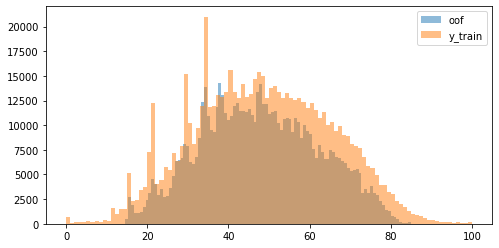

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(oof_train[len(cv_idx[0]["train"]):], bins=100, label="oof", alpha=0.5)
plt.hist(train.iloc[len(cv_idx[0]["train"]):].congestion, bins=100, label="y_train", alpha=0.5)
plt.legend()
plt.show()

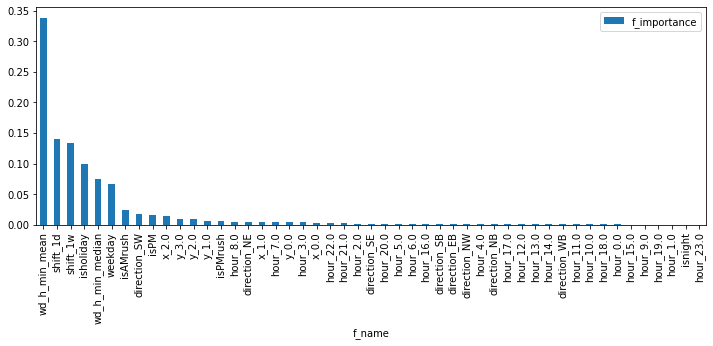

In [ ]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 1, 1)

f_importance = models[-1].feature_importance()
f_importance = f_importance / np.sum(f_importance)
f_name = models[-1].feature_name()

df_importance = pd.DataFrame({"f_name": f_name, "f_importance": f_importance})
df_importance = df_importance.sort_values("f_importance", ascending=False)

df_importance.plot.bar(x="f_name", ax=ax)

### 017-6
017-5の特徴量からisnightを削除

In [ ]:
# load data
train = pd.read_csv("../input/train.csv", index_col="row_id")
test = pd.read_csv("../input/test.csv", index_col="row_id")
train.time = pd.to_datetime(train.time)
test.time = pd.to_datetime(test.time)

In [ ]:
# trainとtestをまとめる
data = pd.concat([train, test])

# 座標と方角をまとめた列を追加
data["loc_dir"] = data.x.astype("str") + data.y.astype("str") + data.direction

In [ ]:
# 時系列の特徴量を追加
data["hour"] = data.time.dt.hour
data["minute"] = data.time.dt.minute
data["weekday"] = data.time.dt.weekday
# data["dayofyear"] = data.time.dt.dayofyear
# data["weekofyear"] = data.time.dt.isocalendar().week
data["isPM"] = (data.hour >= 12).astype("int")
data["isAMrush"] = ((6 <= data.hour) & (data.hour <= 10)).astype("int")
data["isPMrush"] = ((15 <= data.hour) & (data.hour <= 20)).astype("int")
# data["isweekend"] = (data.weekday >= 5).astype("int")
# data["isnight"] = ((data.hour < 5) & (22 < data.hour)).astype("int")
us_holidays = holidays.US()
data["isholiday"] = (data.time.map(lambda x: x in us_holidays)).astype("int")

# trainデータから座標，方角，曜日，時，分ごとの中央値を計算
medians = data.iloc[:len(train)].groupby(["loc_dir", "weekday", "hour", "minute"]).congestion.median()
medians.name = "wd_h_min_median"
# 中央値を追加
data = data.merge(medians, how="left", left_on=["loc_dir", "weekday", "hour", "minute"], right_index=True)

# trainデータから座標，方角，曜日，時，分ごとの平均値を計算
means = data.iloc[:len(train)].groupby(["loc_dir", "weekday", "hour", "minute"]).congestion.mean()
means.name = "wd_h_min_mean"
# 平均値を追加
data = data.merge(means, how="left", left_on=["loc_dir", "weekday", "hour", "minute"], right_index=True)

In [ ]:
# 元データであるかどうかのフラグ
data["org"] = True

# 抜けたデータポイントを補う
time_index = pd.date_range(start=data.time.iloc[0], end=data.time.iloc[-1], freq="20min")
loc_dir = data.loc_dir.unique()
df = pd.DataFrame(list(itertools.product(time_index, loc_dir)), columns=["time","loc_dir"])
data = df.merge(data, how="left", on=["time", "loc_dir"])

# 追加した行のorgフラグはFalseにする
data.org.fillna(False, inplace=True)

In [ ]:
# シフト特徴量のためのカラムを作製
data["shift_feature"] = data.congestion
# 欠損値は中央値で補完
data.shift_feature.fillna(data.wd_h_min_median, inplace=True)

# シフト特徴量作製のため，wide formatに変更
wide_shift_feature = data.pivot(index="time", columns="loc_dir", values="shift_feature")

# 1日，1週間のシフト特徴量を計算
shift_1d = wide_shift_feature.shift(3*24)
shift_1w = wide_shift_feature.shift(3*24*7)
# long formatに戻す
shift_1d = shift_1d.stack()
shift_1d.name = "shift_1d"
shift_1d = shift_1d.reset_index()
shift_1w = shift_1w.stack()
shift_1w.name = "shift_1w"
shift_1w = shift_1w.reset_index()

# 特徴量として追加
data = data.merge(shift_1d, how="left", on=["time", "loc_dir"])
data = data.merge(shift_1w, how="left", on=["time", "loc_dir"])

# 座標，方角，曜日，時間をone-hot-encoding
data = pd.get_dummies(data, columns=["x", "y", "direction", "hour"])

# 元データのみ取り出す
data = data[data.org]

In [ ]:
# trainとtestに再分割
train = data.iloc[:len(train)]
test = data.iloc[len(train):]

# 欠損値のある行を除く
train = train.dropna()

# 特徴量，目的変数に分ける
X_train = train.drop(["time", "loc_dir", "congestion", "minute", "shift_feature", "org"], axis=1)
y_train = train.congestion
X_test = test.drop(["time", "loc_dir", "congestion", "minute", "shift_feature", "org"], axis=1)

In [ ]:
# 保存用の配列
y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv_idx = []


params = {
    "objective": "regression",
    "metric": "mae",
    "learning_rate": 0.05,
}

# 時系列で交差検証
cv = TimeSeriesSplit(n_splits=5)

for fold_idx, (tr_idx, val_idx) in enumerate(cv.split(X_train)):
    cv_idx.append({"train": tr_idx, "valid": val_idx})
    print(f"======== fold: {fold_idx} ========")

    # 学習用，バリデーション用に分割
    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    
    model = lgb.train(params, lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=10,
                      num_boost_round=3000,
                      early_stopping_rounds=10)
    
    oof_train[val_idx] = \
        model.predict(X_val, num_iteration=model.best_iteration)

    y_pred = model.predict(X_test, num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)

======== fold: 0 ========
Training until validation scores don't improve for 10 rounds.
[10]	training's l1: 9.77858	valid_1's l1: 9.74821
[20]	training's l1: 7.66133	valid_1's l1: 7.667
[30]	training's l1: 6.64258	valid_1's l1: 6.67821
[40]	training's l1: 6.18201	valid_1's l1: 6.24529
[50]	training's l1: 5.97704	valid_1's l1: 6.06509
[60]	training's l1: 5.88327	valid_1's l1: 5.99147
[70]	training's l1: 5.83593	valid_1's l1: 5.96089
[80]	training's l1: 5.80881	valid_1's l1: 5.94733
[90]	training's l1: 5.78993	valid_1's l1: 5.94018
[100]	training's l1: 5.7762	valid_1's l1: 5.93682
[110]	training's l1: 5.76385	valid_1's l1: 5.93526
[120]	training's l1: 5.75297	valid_1's l1: 5.93479
[130]	training's l1: 5.74505	valid_1's l1: 5.93472
[140]	training's l1: 5.73826	valid_1's l1: 5.93512
Early stopping, best iteration is:
[132]	training's l1: 5.74335	valid_1's l1: 5.93446
======== fold: 1 ========
Training until validation scores don't improve for 10 rounds.
[10]	training's l1: 9.77329	valid_1'

In [ ]:
with open("../output/y_preds_017-6.pkl", "wb") as f:
    pickle.dump(y_preds, f)

with open("../output/models_017-6.pkl", "wb") as f:
    pickle.dump(models, f)

with open("../output/oof_train_017-6.pkl", "wb") as f:
    pickle.dump(oof_train, f)

In [ ]:
scores = [
    m.best_score["valid_1"]["l1"] for m in models
]
score = sum(scores) / len(scores)
print("=== CV scores ===")
print(scores)
print(score)

=== CV scores ===
[5.934455284280861, 6.004451074717233, 6.15742450358178, 6.033368044635511, 6.338028648455045]
6.093545511134086


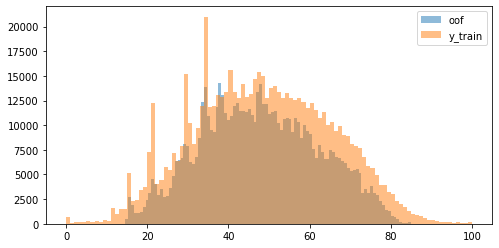

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(oof_train[len(cv_idx[0]["train"]):], bins=100, label="oof", alpha=0.5)
plt.hist(train.iloc[len(cv_idx[0]["train"]):].congestion, bins=100, label="y_train", alpha=0.5)
plt.legend()
plt.show()

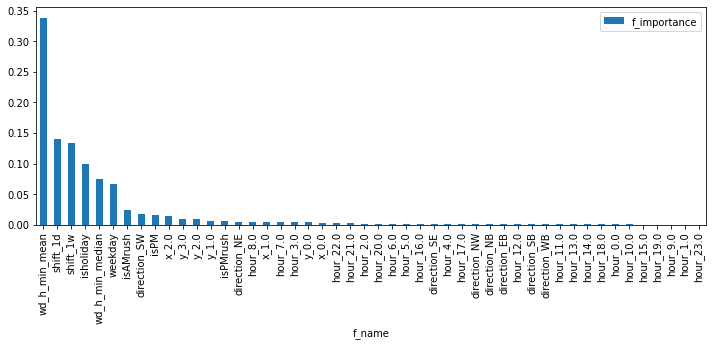

In [ ]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 1, 1)

f_importance = models[-1].feature_importance()
f_importance = f_importance / np.sum(f_importance)
f_name = models[-1].feature_name()

df_importance = pd.DataFrame({"f_name": f_name, "f_importance": f_importance})
df_importance = df_importance.sort_values("f_importance", ascending=False)

df_importance.plot.bar(x="f_name", ax=ax)

### 017-7
017-6のweekdayをone-hot-encoding

In [ ]:
# load data
train = pd.read_csv("../input/train.csv", index_col="row_id")
test = pd.read_csv("../input/test.csv", index_col="row_id")
train.time = pd.to_datetime(train.time)
test.time = pd.to_datetime(test.time)

In [ ]:
# trainとtestをまとめる
data = pd.concat([train, test])

# 座標と方角をまとめた列を追加
data["loc_dir"] = data.x.astype("str") + data.y.astype("str") + data.direction

In [ ]:
# 時系列の特徴量を追加
data["hour"] = data.time.dt.hour
data["minute"] = data.time.dt.minute
data["weekday"] = data.time.dt.weekday
# data["dayofyear"] = data.time.dt.dayofyear
# data["weekofyear"] = data.time.dt.isocalendar().week
data["isPM"] = (data.hour >= 12).astype("int")
data["isAMrush"] = ((6 <= data.hour) & (data.hour <= 10)).astype("int")
data["isPMrush"] = ((15 <= data.hour) & (data.hour <= 20)).astype("int")
# data["isweekend"] = (data.weekday >= 5).astype("int")
# data["isnight"] = ((data.hour < 5) & (22 < data.hour)).astype("int")
us_holidays = holidays.US()
data["isholiday"] = (data.time.map(lambda x: x in us_holidays)).astype("int")

# trainデータから座標，方角，曜日，時，分ごとの中央値を計算
medians = data.iloc[:len(train)].groupby(["loc_dir", "weekday", "hour", "minute"]).congestion.median()
medians.name = "wd_h_min_median"
# 中央値を追加
data = data.merge(medians, how="left", left_on=["loc_dir", "weekday", "hour", "minute"], right_index=True)

# trainデータから座標，方角，曜日，時，分ごとの平均値を計算
means = data.iloc[:len(train)].groupby(["loc_dir", "weekday", "hour", "minute"]).congestion.mean()
means.name = "wd_h_min_mean"
# 平均値を追加
data = data.merge(means, how="left", left_on=["loc_dir", "weekday", "hour", "minute"], right_index=True)

In [ ]:
# 元データであるかどうかのフラグ
data["org"] = True

# 抜けたデータポイントを補う
time_index = pd.date_range(start=data.time.iloc[0], end=data.time.iloc[-1], freq="20min")
loc_dir = data.loc_dir.unique()
df = pd.DataFrame(list(itertools.product(time_index, loc_dir)), columns=["time","loc_dir"])
data = df.merge(data, how="left", on=["time", "loc_dir"])

# 追加した行のorgフラグはFalseにする
data.org.fillna(False, inplace=True)

In [ ]:
# シフト特徴量のためのカラムを作製
data["shift_feature"] = data.congestion
# 欠損値は中央値で補完
data.shift_feature.fillna(data.wd_h_min_median, inplace=True)

# シフト特徴量作製のため，wide formatに変更
wide_shift_feature = data.pivot(index="time", columns="loc_dir", values="shift_feature")

# 1日，1週間のシフト特徴量を計算
shift_1d = wide_shift_feature.shift(3*24)
shift_1w = wide_shift_feature.shift(3*24*7)
# long formatに戻す
shift_1d = shift_1d.stack()
shift_1d.name = "shift_1d"
shift_1d = shift_1d.reset_index()
shift_1w = shift_1w.stack()
shift_1w.name = "shift_1w"
shift_1w = shift_1w.reset_index()

# 特徴量として追加
data = data.merge(shift_1d, how="left", on=["time", "loc_dir"])
data = data.merge(shift_1w, how="left", on=["time", "loc_dir"])

# 座標，方角，曜日，時間をone-hot-encoding
data = pd.get_dummies(data, columns=["x", "y", "direction", "weekday", "hour"])

# 元データのみ取り出す
data = data[data.org]

In [ ]:
# trainとtestに再分割
train = data.iloc[:len(train)]
test = data.iloc[len(train):]

# 欠損値のある行を除く
train = train.dropna()

# 特徴量，目的変数に分ける
X_train = train.drop(["time", "loc_dir", "congestion", "minute", "shift_feature", "org"], axis=1)
y_train = train.congestion
X_test = test.drop(["time", "loc_dir", "congestion", "minute", "shift_feature", "org"], axis=1)

In [ ]:
# 保存用の配列
y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv_idx = []


params = {
    "objective": "regression",
    "metric": "mae",
    "learning_rate": 0.05,
}

# 時系列で交差検証
cv = TimeSeriesSplit(n_splits=5)

for fold_idx, (tr_idx, val_idx) in enumerate(cv.split(X_train)):
    cv_idx.append({"train": tr_idx, "valid": val_idx})
    print(f"======== fold: {fold_idx} ========")

    # 学習用，バリデーション用に分割
    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    
    model = lgb.train(params, lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=10,
                      num_boost_round=3000,
                      early_stopping_rounds=10)
    
    oof_train[val_idx] = \
        model.predict(X_val, num_iteration=model.best_iteration)

    y_pred = model.predict(X_test, num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)

======== fold: 0 ========
Training until validation scores don't improve for 10 rounds.
[10]	training's l1: 9.77858	valid_1's l1: 9.74821
[20]	training's l1: 7.66133	valid_1's l1: 7.667
[30]	training's l1: 6.64246	valid_1's l1: 6.67821
[40]	training's l1: 6.182	valid_1's l1: 6.24556
[50]	training's l1: 5.97595	valid_1's l1: 6.06507
[60]	training's l1: 5.88118	valid_1's l1: 5.99085
[70]	training's l1: 5.83405	valid_1's l1: 5.96057
[80]	training's l1: 5.80603	valid_1's l1: 5.94727
[90]	training's l1: 5.78817	valid_1's l1: 5.94119
[100]	training's l1: 5.77393	valid_1's l1: 5.93792
[110]	training's l1: 5.76178	valid_1's l1: 5.93641
[120]	training's l1: 5.75187	valid_1's l1: 5.93664
Early stopping, best iteration is:
[112]	training's l1: 5.75967	valid_1's l1: 5.93629
======== fold: 1 ========
Training until validation scores don't improve for 10 rounds.
[10]	training's l1: 9.77329	valid_1's l1: 9.89884
[20]	training's l1: 7.6717	valid_1's l1: 7.80363
[30]	training's l1: 6.66182	valid_1's l1

In [ ]:
with open("../output/y_preds_017-7.pkl", "wb") as f:
    pickle.dump(y_preds, f)

with open("../output/models_017-7.pkl", "wb") as f:
    pickle.dump(models, f)

with open("../output/oof_train_017-7.pkl", "wb") as f:
    pickle.dump(oof_train, f)

In [ ]:
scores = [
    m.best_score["valid_1"]["l1"] for m in models
]
score = sum(scores) / len(scores)
print("=== CV scores ===")
print(scores)
print(score)

=== CV scores ===
[5.9362925253760475, 6.004077516010254, 6.159064582896763, 6.03398670391746, 6.336811447498569]
6.094046555139818


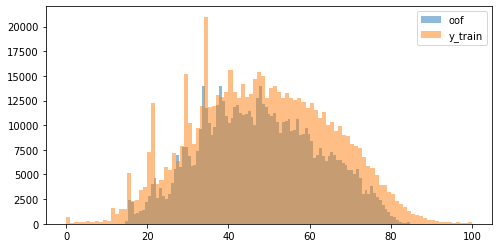

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(oof_train[len(cv_idx[0]["train"]):], bins=100, label="oof", alpha=0.5)
plt.hist(train.iloc[len(cv_idx[0]["train"]):].congestion, bins=100, label="y_train", alpha=0.5)
plt.legend()
plt.show()

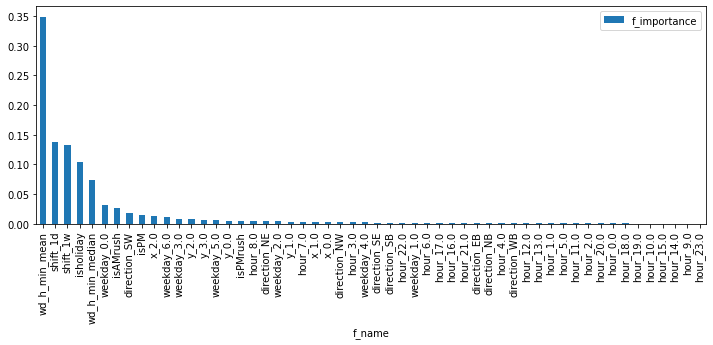

In [ ]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 1, 1)

f_importance = models[-1].feature_importance()
f_importance = f_importance / np.sum(f_importance)
f_name = models[-1].feature_name()

df_importance = pd.DataFrame({"f_name": f_name, "f_importance": f_importance})
df_importance = df_importance.sort_values("f_importance", ascending=False)

df_importance.plot.bar(x="f_name", ax=ax)

### 017-8
017-6の座標と方角をまとめた特徴量とする

In [ ]:
# load data
train = pd.read_csv("../input/train.csv", index_col="row_id")
test = pd.read_csv("../input/test.csv", index_col="row_id")
train.time = pd.to_datetime(train.time)
test.time = pd.to_datetime(test.time)

In [ ]:
# trainとtestをまとめる
data = pd.concat([train, test])

# 座標と方角をまとめた列を追加
data["loc_dir"] = data.x.astype("str") + data.y.astype("str") + data.direction

In [ ]:
# 時系列の特徴量を追加
data["hour"] = data.time.dt.hour
data["minute"] = data.time.dt.minute
data["weekday"] = data.time.dt.weekday
# data["dayofyear"] = data.time.dt.dayofyear
# data["weekofyear"] = data.time.dt.isocalendar().week
data["isPM"] = (data.hour >= 12).astype("int")
data["isAMrush"] = ((6 <= data.hour) & (data.hour <= 10)).astype("int")
data["isPMrush"] = ((15 <= data.hour) & (data.hour <= 20)).astype("int")
# data["isweekend"] = (data.weekday >= 5).astype("int")
# data["isnight"] = ((data.hour < 5) & (22 < data.hour)).astype("int")
us_holidays = holidays.US()
data["isholiday"] = (data.time.map(lambda x: x in us_holidays)).astype("int")

# trainデータから座標，方角，曜日，時，分ごとの中央値を計算
medians = data.iloc[:len(train)].groupby(["loc_dir", "weekday", "hour", "minute"]).congestion.median()
medians.name = "wd_h_min_median"
# 中央値を追加
data = data.merge(medians, how="left", left_on=["loc_dir", "weekday", "hour", "minute"], right_index=True)

# trainデータから座標，方角，曜日，時，分ごとの平均値を計算
means = data.iloc[:len(train)].groupby(["loc_dir", "weekday", "hour", "minute"]).congestion.mean()
means.name = "wd_h_min_mean"
# 平均値を追加
data = data.merge(means, how="left", left_on=["loc_dir", "weekday", "hour", "minute"], right_index=True)

In [ ]:
# 元データであるかどうかのフラグ
data["org"] = True

# 抜けたデータポイントを補う
time_index = pd.date_range(start=data.time.iloc[0], end=data.time.iloc[-1], freq="20min")
loc_dir = data.loc_dir.unique()
df = pd.DataFrame(list(itertools.product(time_index, loc_dir)), columns=["time","loc_dir"])
data = df.merge(data, how="left", on=["time", "loc_dir"])

# 追加した行のorgフラグはFalseにする
data.org.fillna(False, inplace=True)

In [ ]:
# シフト特徴量のためのカラムを作製
data["shift_feature"] = data.congestion
# 欠損値は中央値で補完
data.shift_feature.fillna(data.wd_h_min_median, inplace=True)

# シフト特徴量作製のため，wide formatに変更
wide_shift_feature = data.pivot(index="time", columns="loc_dir", values="shift_feature")

# 1日，1週間のシフト特徴量を計算
shift_1d = wide_shift_feature.shift(3*24)
shift_1w = wide_shift_feature.shift(3*24*7)
# long formatに戻す
shift_1d = shift_1d.stack()
shift_1d.name = "shift_1d"
shift_1d = shift_1d.reset_index()
shift_1w = shift_1w.stack()
shift_1w.name = "shift_1w"
shift_1w = shift_1w.reset_index()

# 特徴量として追加
data = data.merge(shift_1d, how="left", on=["time", "loc_dir"])
data = data.merge(shift_1w, how="left", on=["time", "loc_dir"])

# 時間をone-hot-encoding
data = pd.get_dummies(data, columns=["hour"])

# loc_dirをlabel-encoding
le = LabelEncoder()
data.loc_dir = le.fit_transform(data.loc_dir)

# 元データのみ取り出す
data = data[data.org]

In [ ]:
# trainとtestに再分割
train = data.iloc[:len(train)]
test = data.iloc[len(train):]

# 欠損値のある行を除く
train = train.dropna()

# 特徴量，目的変数に分ける
X_train = train.drop(["time", "x", "y", "direction", "congestion", "minute", "shift_feature", "org"], axis=1)
y_train = train.congestion
X_test = test.drop(["time", "x", "y", "direction", "congestion", "minute", "shift_feature", "org"], axis=1)

In [ ]:
# 保存用の配列
y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv_idx = []


params = {
    "objective": "regression",
    "metric": "mae",
    "learning_rate": 0.05,
}

# 時系列で交差検証
cv = TimeSeriesSplit(n_splits=5)

for fold_idx, (tr_idx, val_idx) in enumerate(cv.split(X_train)):
    cv_idx.append({"train": tr_idx, "valid": val_idx})
    print(f"======== fold: {fold_idx} ========")

    # 学習用，バリデーション用に分割
    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    
    model = lgb.train(params, lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=10,
                      num_boost_round=3000,
                      early_stopping_rounds=10)
    
    oof_train[val_idx] = \
        model.predict(X_val, num_iteration=model.best_iteration)

    y_pred = model.predict(X_test, num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)

======== fold: 0 ========
Training until validation scores don't improve for 10 rounds.
[10]	training's l1: 9.79281	valid_1's l1: 9.73426
[20]	training's l1: 7.67128	valid_1's l1: 7.64996
[30]	training's l1: 6.65213	valid_1's l1: 6.6576
[40]	training's l1: 6.19219	valid_1's l1: 6.22396
[50]	training's l1: 5.98737	valid_1's l1: 6.04184
[60]	training's l1: 5.89493	valid_1's l1: 5.96954
[70]	training's l1: 5.84694	valid_1's l1: 5.93922
[80]	training's l1: 5.81886	valid_1's l1: 5.92612
[90]	training's l1: 5.80026	valid_1's l1: 5.92103
[100]	training's l1: 5.78594	valid_1's l1: 5.91817
[110]	training's l1: 5.77562	valid_1's l1: 5.91813
[120]	training's l1: 5.76586	valid_1's l1: 5.91835
Early stopping, best iteration is:
[118]	training's l1: 5.76776	valid_1's l1: 5.9179
======== fold: 1 ========
Training until validation scores don't improve for 10 rounds.
[10]	training's l1: 9.77481	valid_1's l1: 9.83966
[20]	training's l1: 7.67114	valid_1's l1: 7.74439
[30]	training's l1: 6.65916	valid_1's

In [ ]:
with open("../output/y_preds_017-8.pkl", "wb") as f:
    pickle.dump(y_preds, f)

with open("../output/models_017-8.pkl", "wb") as f:
    pickle.dump(models, f)

with open("../output/oof_train_017-8.pkl", "wb") as f:
    pickle.dump(oof_train, f)

In [ ]:
scores = [
    m.best_score["valid_1"]["l1"] for m in models
]
score = sum(scores) / len(scores)
print("=== CV scores ===")
print(scores)
print(score)

=== CV scores ===
[5.917896983591576, 5.945522372509654, 6.230131087792013, 6.023468929266902, 6.22476209441892]
6.068356293515813


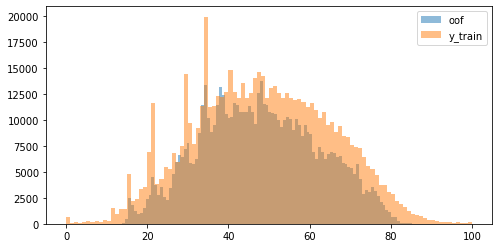

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(oof_train[len(cv_idx[0]["train"]):], bins=100, label="oof", alpha=0.5)
plt.hist(train.iloc[len(cv_idx[0]["train"]):].congestion, bins=100, label="y_train", alpha=0.5)
plt.legend()
plt.show()

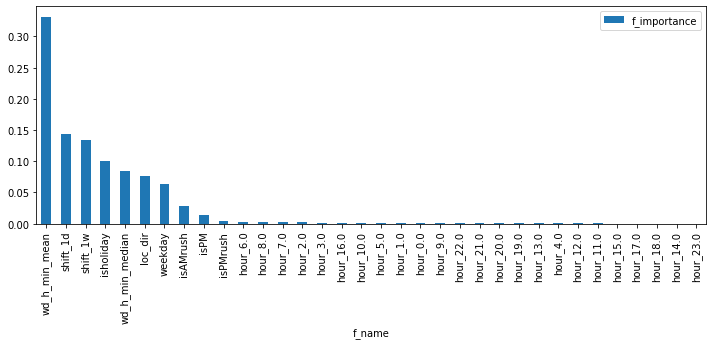

In [ ]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 1, 1)

f_importance = models[-1].feature_importance()
f_importance = f_importance / np.sum(f_importance)
f_name = models[-1].feature_name()

df_importance = pd.DataFrame({"f_name": f_name, "f_importance": f_importance})
df_importance = df_importance.sort_values("f_importance", ascending=False)

df_importance.plot.bar(x="f_name", ax=ax)

### submit

In [1]:
with open("../output/y_preds_017-6.pkl", "rb") as f:
    y_preds = pickle.load(f)

submission = pd.read_csv("../input/sample_submission.csv")
submission.congestion = y_preds[-1]

submission.to_csv("../submit/submission_017-6.csv", index=False)

FileNotFoundError: ignored

In [ ]:
import json
with open('../../kaggle.json') as f:
    json_data = json.load(f)
    os.environ["KAGGLE_USERNAME"] = json_data["username"]
    os.environ["KAGGLE_KEY"] = json_data["key"]

!pip install kaggle --upgrade
!kaggle -v

Kaggle API 1.5.12


In [ ]:
# submission
!kaggle competitions submit tabular-playground-series-mar-2022 -f ../submit/submission_017-6.csv -m "017-6"

100% 57.5k/57.5k [00:00<00:00, 88.0kB/s]
Successfully submitted to Tabular Playground Series - Mar 2022